In [18]:
# Importing the required libraries
import glob
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Activation, concatenate, Conv2DTranspose,MaxPooling2D,Input,Cropping2D,Lambda,Dropout,BatchNormalization
from tensorflow.keras.models import Model

In [19]:
# File path of both images and labels
image_path = '/content/drive/MyDrive/Colab Notebooks/ML-FILES/images'
label_path = '/content/drive/MyDrive/Colab Notebooks/ML-FILES/labels'

In [20]:
# Importing the images and labels
image = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/ML-FILES/images/*.tif'))
labels = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/ML-FILES/labels/*.tif'))

In [58]:
#print(image)
#print(label)

In [57]:
# Since there was a small mistake in the naming of the dataset, i am removing those here
images = []
for i in image:
  if i.endswith('(1).tif'):
    continue
  else:
    images.append(i)

#print(images)
#print(labels)

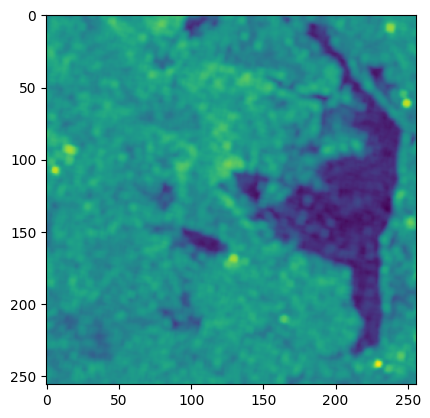

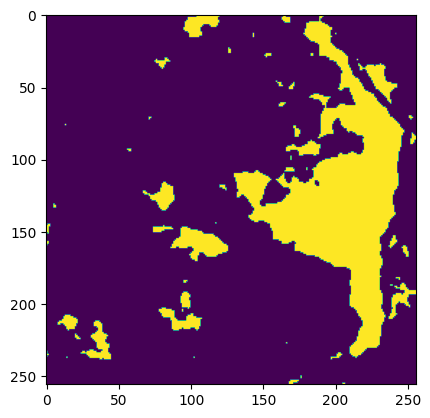

In [23]:
# Visualizing both the image and mask
img = Image.open(images[11])
np_img = np.array(img)
norm_img = 255*(np_img-np_img.min())/(np_img.max()-np_img.min())
plt.imshow(norm_img)
plt.show()


lbl = Image.open(labels[11])
np_lbl = np.array(lbl)
plt.imshow(np_lbl)
plt.show()

In [24]:
# Split the dataset into training and testing datas
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [56]:
#print(X_train)
#print(y_train)

In [26]:
# Convert the image and labels into numpy array to feed them into the UNet model
length_train = len(X_train)
length_test = len(X_test)

X_train1 = np.zeros((length_train, 256, 256, 1))
y_train1 = np.zeros((length_train, 256, 256, 1))
X_test1 = np.zeros((length_test, 256, 256, 1))
y_test1 = np.zeros((length_test, 256, 256, 1))

for i,(image,mask) in enumerate(zip(X_train,y_train)):
  img = Image.open(image)
  img_np = np.array(img).reshape(256,256,1)
  norm_img_1 = 255 * (img_np - img_np.min()) / (img_np.max() - img_np.min())
  X_train1[i] = norm_img_1

  mas = Image.open(mask)
  mas_np = np.array(mas).reshape(256,256,1)
  y_train1[i] = mas_np


for i,(image,mask) in enumerate(zip(X_test,y_test)):

  img = Image.open(image)
  img_np = np.array(img).reshape(256,256,1)
  norm_img_1 = 255 * (img_np - img_np.min()) / (img_np.max() - img_np.min())
  X_test1[i] =  norm_img_1

  mas = Image.open(mask)
  mas_np = np.array(mas).reshape(256,256,1)
  y_test1[i] = mas_np

In [27]:
# The Modified UNet Architecture

img_width = 256
img_height = 256
bands = 1

# ENCODER
input = Input((img_width, img_height, bands))
scaled_input = Lambda(lambda x: x / 255)(input)

# Encoder block 1
s1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(scaled_input)
s1 = BatchNormalization(axis=3)(s1)
s1 = Activation('relu')(s1)
s1 = Dropout(0.1)(s1)
s1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(s1)
s1 = BatchNormalization(axis=3)(s1)
s1 = Activation('relu')(s1)
p1 = MaxPooling2D(pool_size=(2, 2))(s1)

# Encoder block 2
s2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
s2 = BatchNormalization(axis=3)(s2)
s2 = Activation('relu')(s2)
s2 = Dropout(0.1)(s2)
s2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(s2)
s2 = BatchNormalization(axis=3)(s2)
s2 = Activation('relu')(s2)
p2 = MaxPooling2D(pool_size=(2, 2))(s2)

# Encoder block 3
s3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
s3 = BatchNormalization(axis=3)(s3)
s3 = Activation('relu')(s3)
s3 = Dropout(0.2)(s3)
s3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(s3)
s3 = BatchNormalization(axis=3)(s3)
s3 = Activation('relu')(s3)
p3 = MaxPooling2D(pool_size=(2, 2))(s3)

# Encoder block 4
s4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
s4 = BatchNormalization(axis=3)(s4)
s4 = Activation('relu')(s4)
s4 = Dropout(0.2)(s4)
s4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(s4)
s4 = BatchNormalization(axis=3)(s4)
s4 = Activation('relu')(s4)
p4 = MaxPooling2D(pool_size=(2, 2))(s4)

# Base block
s5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p4)
s5 = BatchNormalization(axis=3)(s5)
s5 = Activation('relu')(s5)
s5 = Dropout(0.3)(s5)
s5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(s5)
s5 = BatchNormalization(axis=3)(s5)
s5 = Activation('relu')(s5)

# DECODER
# Decoder block 1
u1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(s5)
u1 = concatenate([s4, u1])
s6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(u1)
s6 = BatchNormalization(axis=3)(s6)
s6 = Activation('relu')(s6)
s6 = Dropout(0.2)(s6)
s6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(s6)
s6 = BatchNormalization(axis=3)(s6)
s6 = Activation('relu')(s6)

# Decoder block 2
u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(s6)
u2 = concatenate([s3, u2])
s7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(u2)
s7 = BatchNormalization(axis=3)(s7)
s7 = Activation('relu')(s7)
s7 = Dropout(0.2)(s7)
s7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(s7)
s7 = BatchNormalization(axis=3)(s7)
s7 = Activation('relu')(s7)

# Decoder block 3
u3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(s7)
u3 = concatenate([s2, u3])
s8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u3)
s8 = BatchNormalization(axis=3)(s8)
s8 = Activation('relu')(s8)
s8 = Dropout(0.1)(s8)
s8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(s8)
s8 = BatchNormalization(axis=3)(s8)
s8 = Activation('relu')(s8)

# Decoder block 4
u4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(s8)
u4 = concatenate([s1, u4])
s9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(u4)
s9 = BatchNormalization(axis=3)(s9)
s9 = Activation('relu')(s9)
s9 = Dropout(0.1)(s9)
s9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(s9)
s9 = BatchNormalization(axis=3)(s9)
s9 = Activation('relu')(s9)

output = Conv2D(1, (1, 1), activation='sigmoid')(s9)

model = Model(inputs=input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256, 256, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├──────────────────────

 Total params: 1,946,705 (7.43 MB)

 Trainable params: 1,943,761 (7.41 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [28]:
model.fit(X_train1,y_train1,epochs=10,batch_size=3,validation_data=(X_test1,y_test1))

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 468s 3s/step - accuracy: 0.8631 - loss: 0.3938 - val_accuracy: 0.9309 - val_loss: 0.1931
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.9359 - loss: 0.1994 - val_accuracy: 0.9291 - val_loss: 0.1849
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.9378 - loss: 0.1702 - val_accuracy: 0.9537 - val_loss: 0.1285
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 444s 3s/step - accuracy: 0.9429 - loss: 0.1502 - val_accuracy: 0.9520 - val_loss: 0.1450
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.9451 - loss: 0.1404 - val_accuracy: 0.7753 - val_loss: 1.1108
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 410s 3s/step - accuracy: 0.9375 - loss: 0.1637 - val_accuracy: 0.9581 - val_loss: 0.1111
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - accuracy: 0.9453 - loss: 0.1400 - val_accuracy: 0.9613 - val_loss: 0.1001
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 449s 3s/step - accuracy: 0.9510 - loss: 0.1221 - val_accu

In [29]:
model.save('/content/drive/MyDrive/Colab Notebooks/ML-FILES/MODELS/Flood segmentation model chennai.keras')

<Axes: >

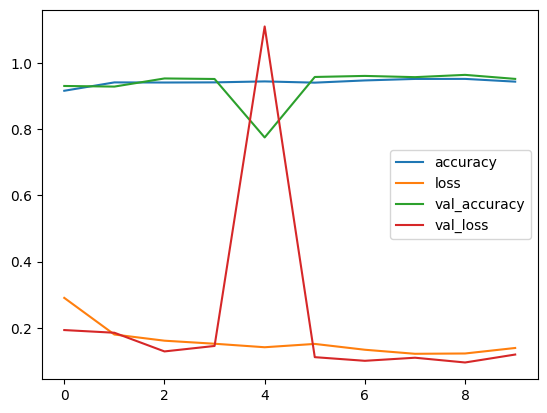

In [30]:
df_loss = pd.DataFrame(model.history.history)
df_loss.plot()

In [32]:
predictions = model.predict(X_test1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step


In [34]:
threshold = 0.5
predicted_test = (predictions > threshold).astype(np.uint8)
print(np.unique(predicted_test))

[0 1]


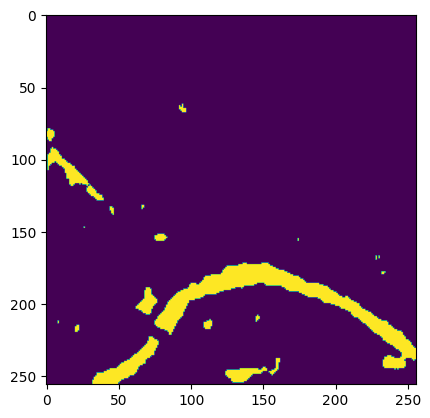

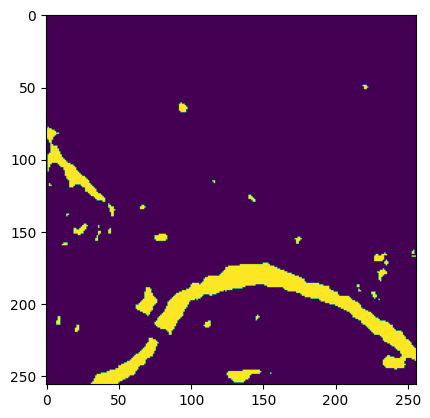

In [38]:
plt.imshow(predicted_test[12,:,:,0])
plt.show()
plt.imshow(y_test1[12,:,:,0])
plt.show()